In [1]:
%reload_ext autoreload
%autoreload 2

import vtk
from vtk.util import numpy_support

import numpy as np
import bloscpack as bp

import sys
import os
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from annotation_utilities import *

from skimage.measure import mesh_surface_area, marching_cubes, correct_mesh_orientation

from itertools import izip
import pandas as pd

import time

import matplotlib.pyplot as plt
%matplotlib inline

from vis3d_utilities import *

/usr/lib/python2.7/dist-packages/pkg_resources.py:1031: UserWarning: /home/yuncong/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [2]:
volume_dir = '/home/yuncong/CSHL_volumes/'
mesh_rootdir = create_if_not_exists('/home/yuncong/CSHL_meshes')

In [3]:
volume_landmark_names_unsided = ['12N', '5N', '6N', '7N', '7n', 'AP', 'Amb', 'LC',
                                 'LRt', 'Pn', 'R', 'RtTg', 'Tz', 'VLL', 'sp5']
linear_landmark_names_unsided = ['outerContour']

labels_unsided = volume_landmark_names_unsided + linear_landmark_names_unsided
labels_unsided_indices = dict((j, i+1) for i, j in enumerate(labels_unsided))  # BackG always 0

labelMap_unsidedToSided = {'12N': ['12N'],
                            '5N': ['5N_L', '5N_R'],
                            '6N': ['6N_L', '6N_R'],
                            '7N': ['7N_L', '7N_R'],
                            '7n': ['7n_L', '7n_R'],
                            'AP': ['AP'],
                            'Amb': ['Amb_L', 'Amb_R'],
                            'LC': ['LC_L', 'LC_R'],
                            'LRt': ['LRt_L', 'LRt_R'],
                            'Pn': ['Pn_L', 'Pn_R'],
                            'R': ['R_L', 'R_R'],
                            'RtTg': ['RtTg'],
                            'Tz': ['Tz_L', 'Tz_R'],
                            'VLL': ['VLL_L', 'VLL_R'],
                            'sp5': ['sp5'],
                           'outerContour': ['outerContour']}

labelMap_sidedToUnsided = {n: nu for nu, ns in labelMap_unsidedToSided.iteritems() for n in ns}

from itertools import chain
labels_sided = list(chain(*(labelMap_unsidedToSided[name_u] for name_u in labels_unsided)))
labels_sided_indices = dict((j, i+1) for i, j in enumerate(labels_sided)) # BackG always 0

In [ ]:
# stack = 'MD594'

# labels_twoSides = []
# labels_twoSides_indices = {}
# with open(volume_dir + '/annotationVolume_withOuterContour_labelIndices.txt' % {'stack': stack}, 'r') as f:
#     lines = f.readlines()
#     for line in lines:
#         name, index = line.split()
#         labels_twoSides.append(name)
#         labels_twoSides_indices[name] = int(index)

In [ ]:
# labelMap_sidedToUnsided = {name: name if '_' not in name else name[:-2] for name in labels_twoSides_indices.keys()}
# labels_unsided = ['BackG'] + sorted(set(labelMap_sidedToUnsided.values()) - {'BackG', 'outerContour'}) + ['outerContour']
# labels_unsided_indices = dict((j, i) for i, j in enumerate(labels_unsided))

# from collections import defaultdict

# labelMap_unsidedToSided = defaultdict(list)
# for name_sided, name_unsided in labelMap_sidedToUnsided.iteritems():
#     labelMap_unsidedToSided[name_unsided].append(name_sided)
# labelMap_unsidedToSided.default_factory = None

In [9]:
stack = 'MD585'
volume = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_atlasProjectedVolume.bp' % {'stack':stack})

available_labels_sided = [labels_sided[i-1] for i in np.unique(volume) if i > 0]
available_labels_unsided = set([labelMap_sidedToUnsided[name] for name in available_labels_sided ])

volume1_landmark_bboxes = {name: bbox_3d(volume == labels_sided_indices[name])
                           for name in available_labels_sided}

mesh_dir = create_if_not_exists(os.path.join(mesh_rootdir, stack))

In [29]:
# stack = 'MD594'
# volume1_landmark_bboxes = {}
# with open(volume_dir+'/%(stack)s/volume_%(stack)s_annotation_withOuterContour_landmarkBboxes.txt' % {'stack': stack}, 'r') as f:
#     lines = f.readlines()
#     for l in lines:
#         s = l.split()
#         volume1_landmark_bboxes[s[0]] = map(int, s[1:]) # xmin, xmax, ymin, ymax, zmin, zmax

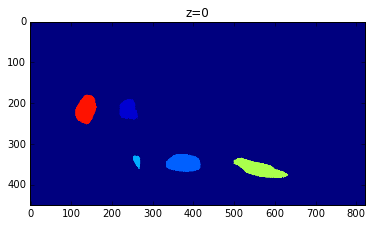

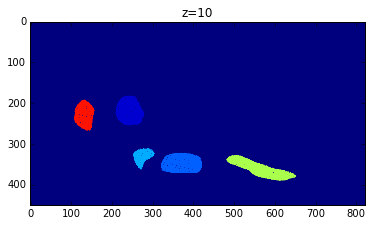

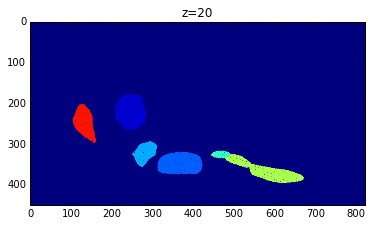

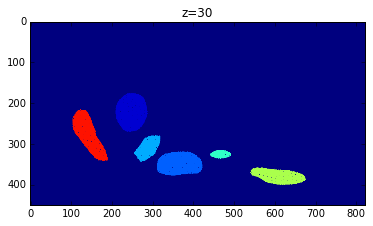

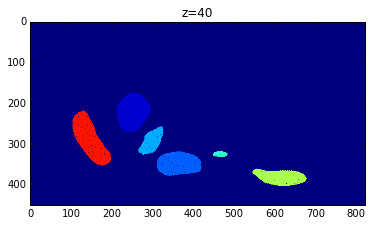

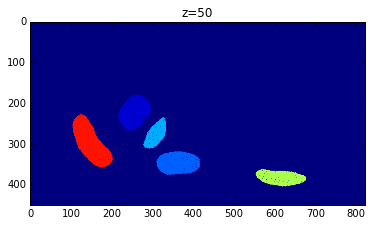

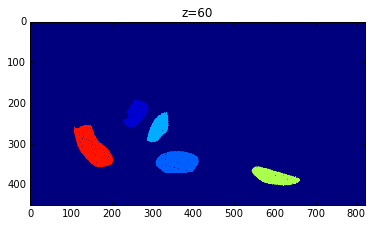

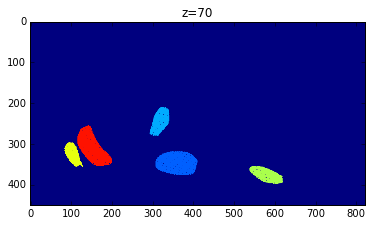

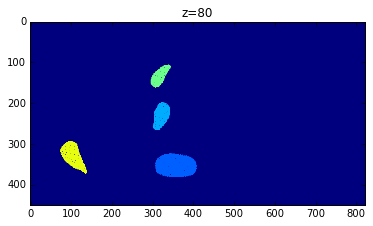

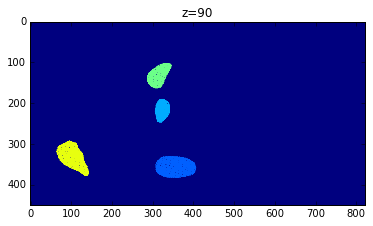

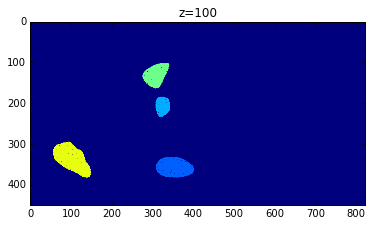

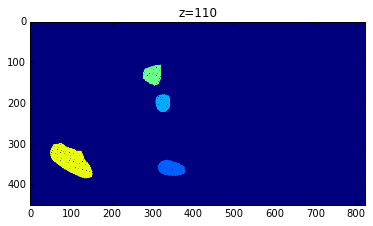

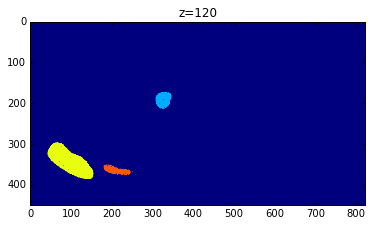

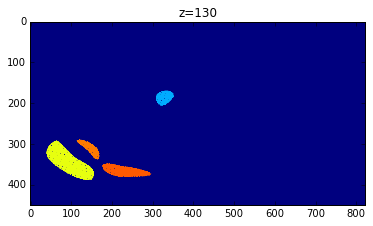

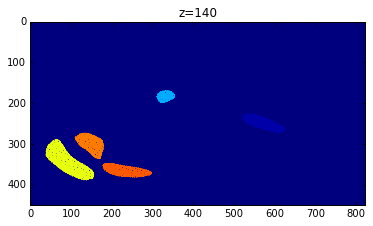

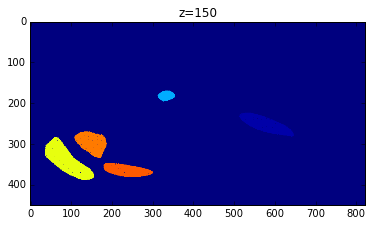

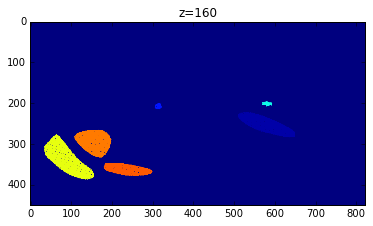

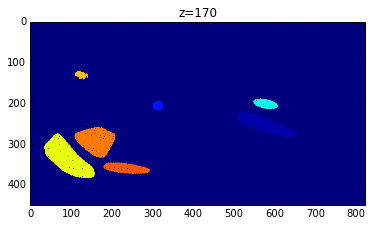

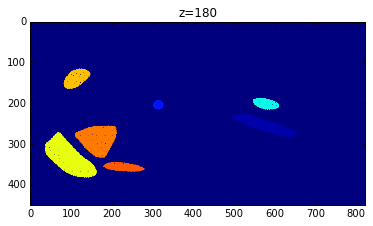

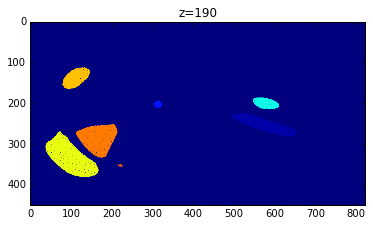

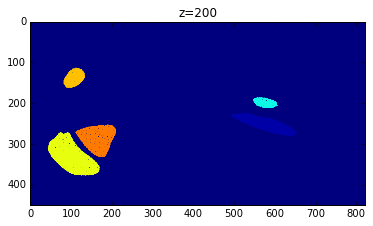

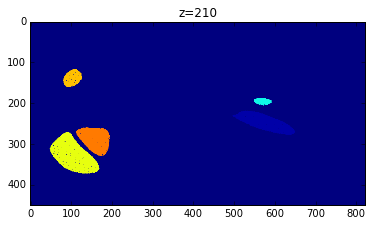

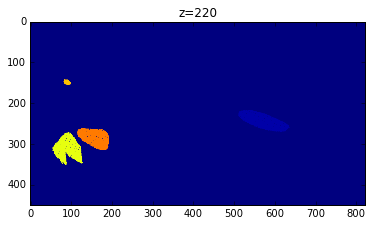

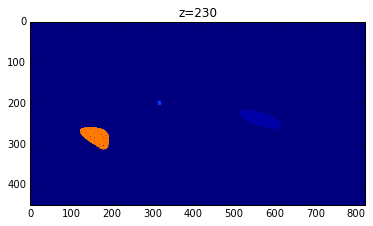

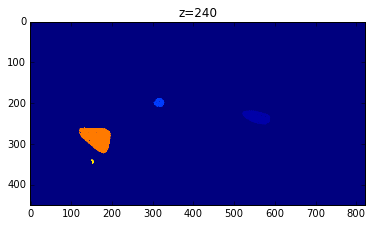

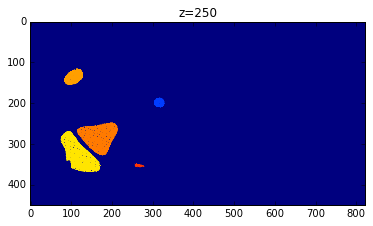

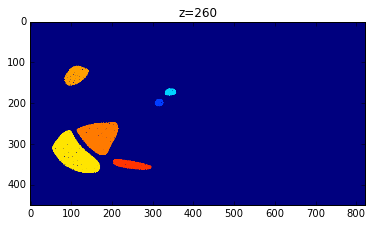

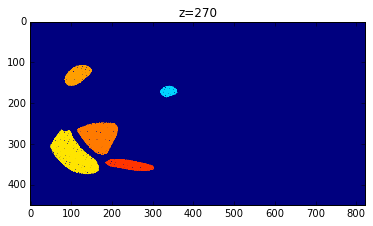

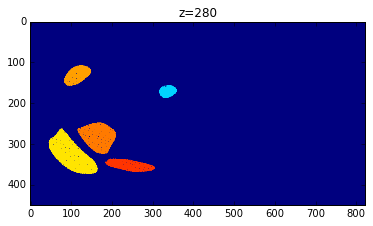

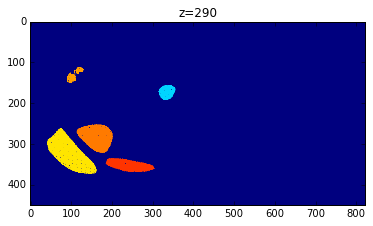

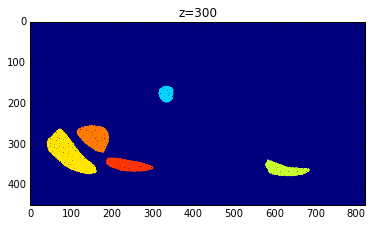

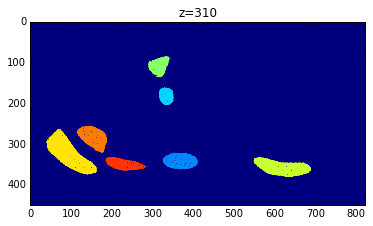

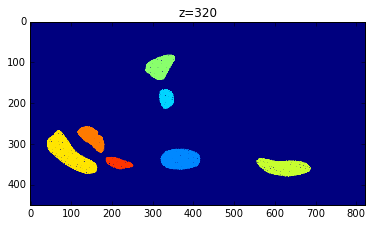

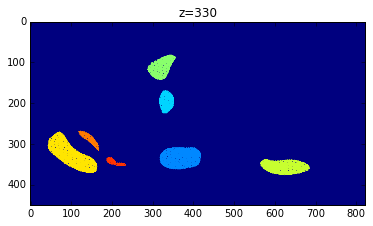

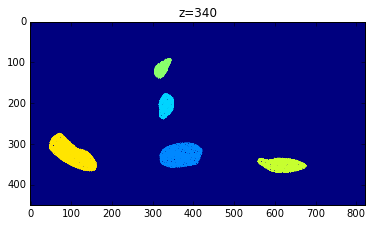

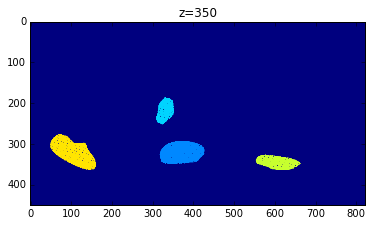

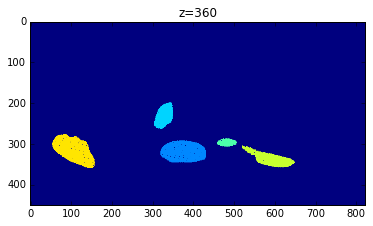

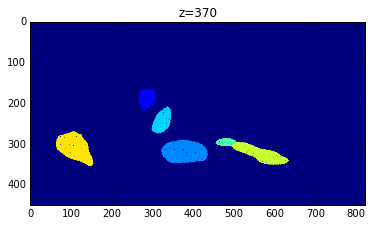

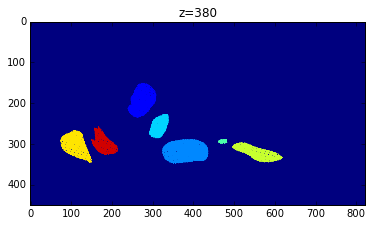

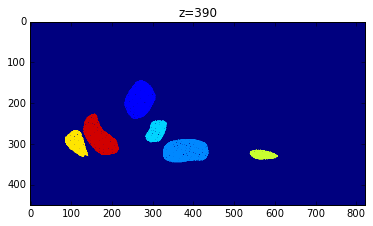

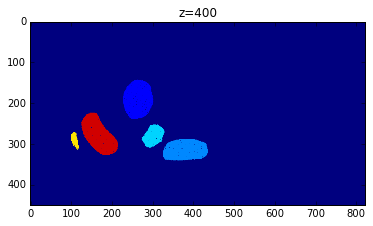

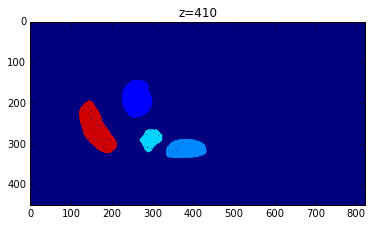

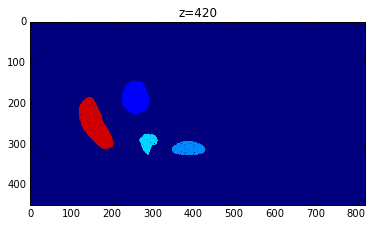

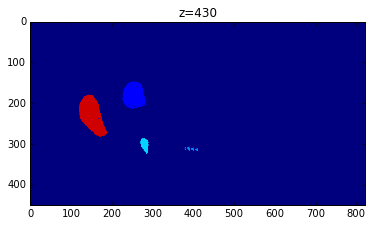

In [21]:
for z in range(0, volume.shape[-1], 10):
    plt.title('z=%d' % z);
    plt.imshow(volume[:,:,z], vmin=0, vmax=len(labels_sided));
    plt.show();

In [17]:
#### for stack in ['MD589', 'MD593']:
# for stack in ['MD594']:
    
#     volume_xmin, volume_xmax, volume_ymin, volume_ymax, volume_zmin, volume_zmax = \
#         np.loadtxt('/home/yuncong/CSHL_volumes/volume_%(stack)s_annotation_withOuterContour_limits.txt' % {'stack': stack})
        
#     _, voxel_size_xy, section_zdistance = np.loadtxt('/home/yuncong/CSHL_volumes/volume_%(stack)s_annotation_resolution.txt' % {'stack': stack})
        

#     data_matrix_int = bp.unpack_ndarray_file('/home/yuncong/CSHL_volumes/volume_%(stack)s_annotation_smoothed.bp' % {'stack': stack})
#     data_matrix = data_matrix_int.astype(np.uint8)
#     del data_matrix_int

# data_matrix = bp.unpack_ndarray_file('/home/yuncong/CSHL_volumes/%(stack)s/volume_%(stack)s_annotation_withOuterContour.bp' % {'stack': stack}).astype(np.uint8)    
data_matrix = volume.astype(np.uint8)
print data_matrix.shape

# for name_s in available_labels_sided:
for name_s in ['7N_R']:

    if name_s not in volume1_landmark_bboxes:
        continue

    print name_s

    xmin, xmax, ymin, ymax, zmin, zmax = volume1_landmark_bboxes[name_s]

    vol = (data_matrix[ymin:ymax+1, xmin:xmax+1, zmin:zmax+1] == labels_sided_indices[name_s]).astype(np.float)
    
    t = time.time()
#     if name_s == 'sp5':
#         polydata = volume_to_polydata(vol, origin=(xmin,ymin,zmin), num_simplify_iter=3, smooth=True)
#     else:
    polydata = volume_to_polydata(vol, origin=(xmin,ymin,zmin), num_simplify_iter=3, smooth=True)

    sys.stderr.write('time: %.2f\n' % (time.time() - t) ) # ~ 150s for outerContour; 93s for sp5
    
    save_mesh_stl(polydata, mesh_dir + "/%(stack)s_atlasProjectedVolume_%(name)s_smoothed.stl" % {'stack': stack, 'name': name_s})

(450, 822, 438)
7N_R
area: 44902.20

marching cube: 0.16 seconds
compute surface area: 0.02 seconds
fill point array: 0.10 seconds
fill cell array: 0.00 seconds
mesh_to_polydata: 0.11 seconds
simplify 0 @ 86592: 0.58 seconds
simplify 1 @ 35724: 0.59 seconds
simplify 2 @ 35724: 0.14 seconds


time: 1.60


In [14]:
volume_list = {}
origin_list = {}
polydata_list = {}
# imagedata_list = {}

# for stack in ['MD594']:
# for name_s in labels_sided:
for name_s in ['7N_L']:

    if name_s not in volume1_landmark_bboxes:
        continue

    print name_s

    fn = mesh_dir + '/%(stack)s/%(stack)s_atlasProjectedVolume_%(label)s_smoothed.stl' % {'stack': stack, 'label': name_s}

    reader = vtk.vtkSTLReader()
    reader.SetFileName(fn)
    reader.Update()

    polydata = reader.GetOutput()
    polydata_list[name_s] = polydata

    t = time.time()
    vol, origin, _ = polydata_to_volume(polydata)
    sys.stderr.write('time: %.2f\n' % (time.time() - t) ) # ~ 180s; 270s outerContour
    
    volume_list[name_s] = vol > 0
    origin_list[name_s] = origin
#         imagedata_list[l] = imageData

7N_L


ValueError: negative dimensions are not allowed

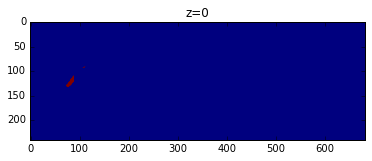

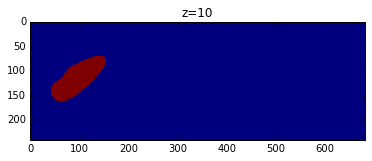

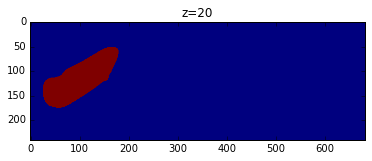

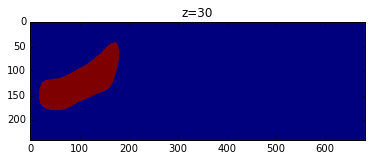

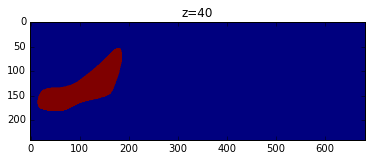

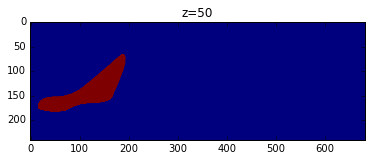

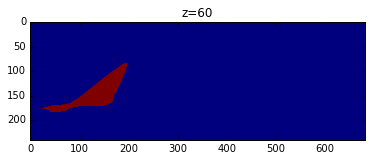

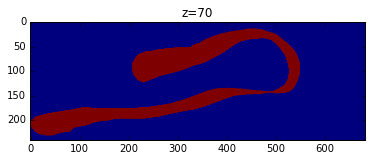

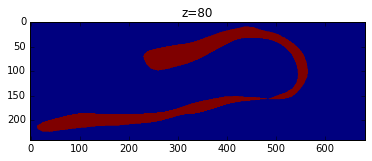

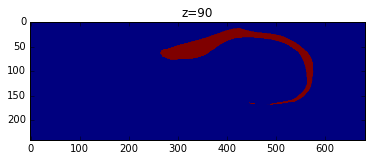

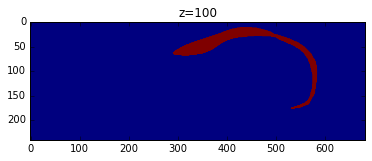

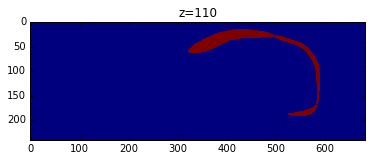

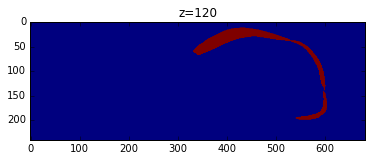

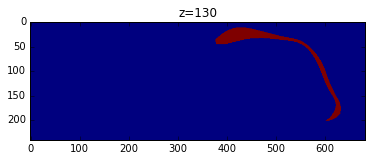

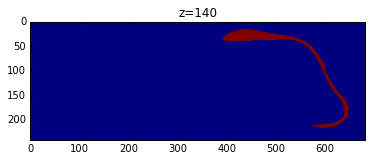

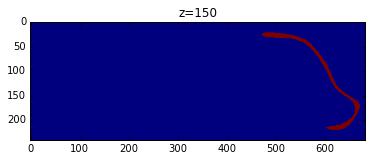

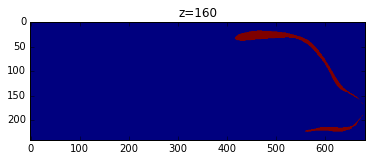

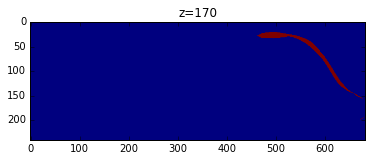

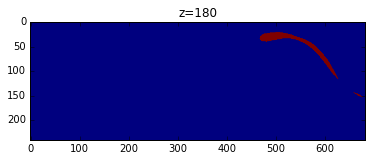

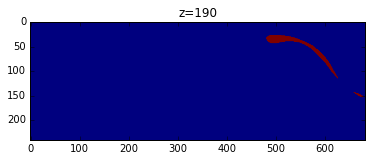

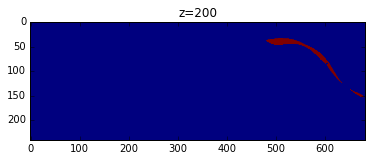

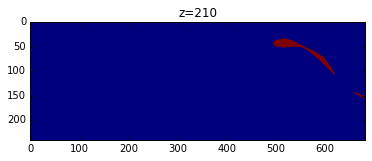

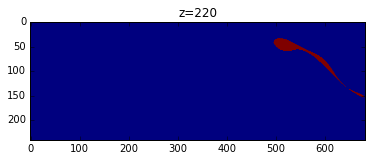

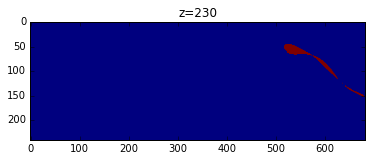

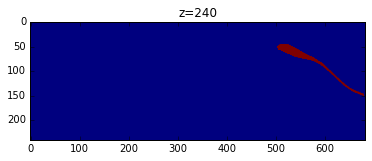

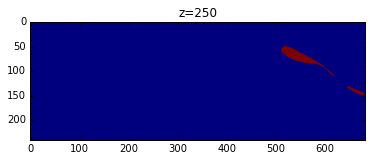

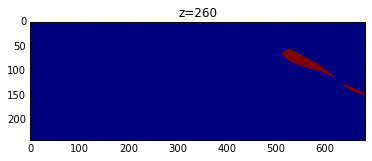

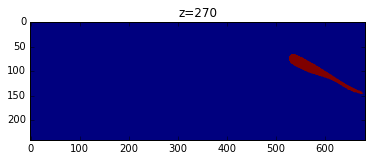

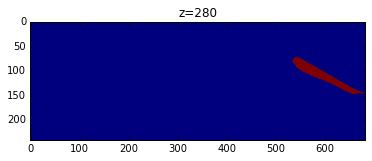

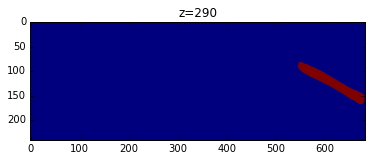

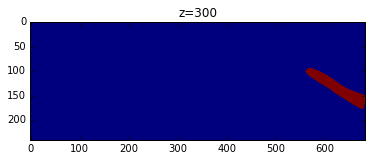

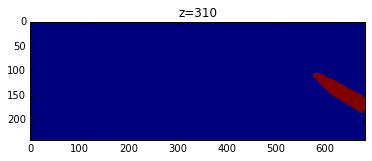

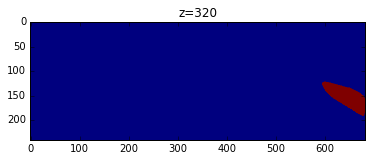

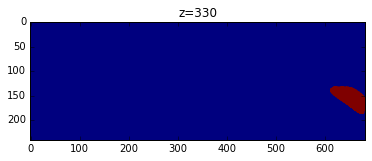

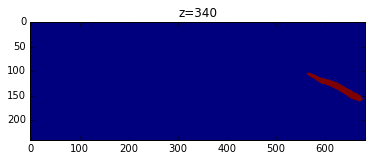

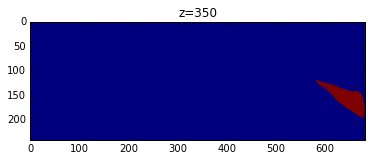

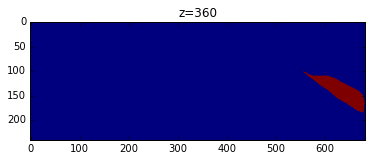

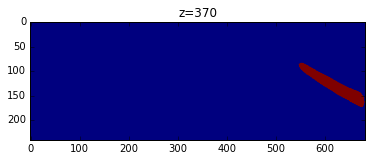

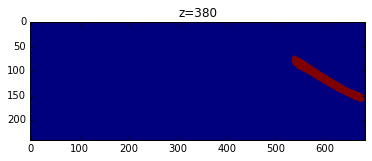

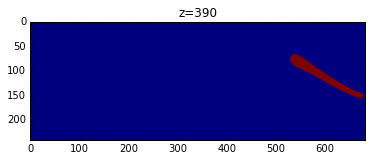

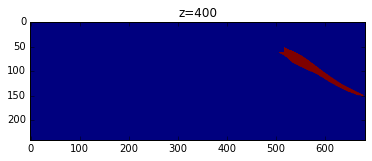

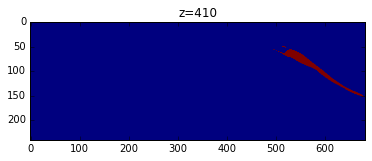

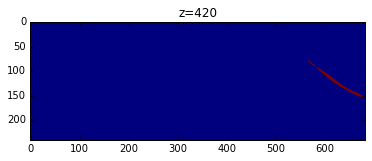

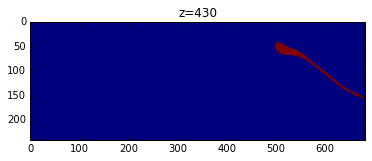

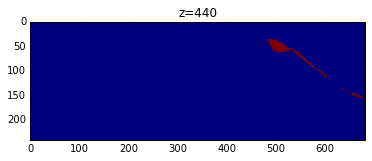

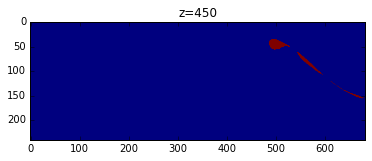

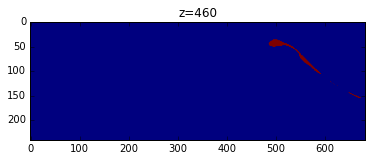

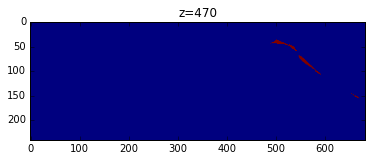

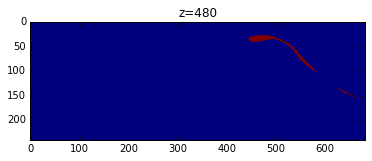

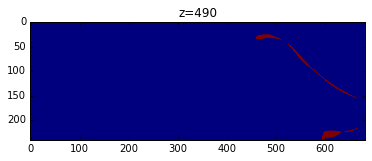

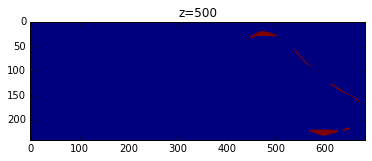

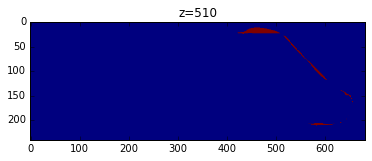

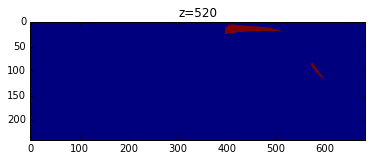

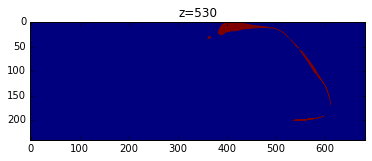

In [41]:
l = 'sp5'

v = volume_list[l]
for z in range(0, v.shape[2], 10):
    plt.title('z=%d' % z);
    plt.imshow(v[:,:,z]);
    plt.show();
    
# v = volume_gaussianSmoothed_list[l]
# for z in range(0, v.shape[2], 10):
#     plt.imshow(v[:,:,z]);
#     plt.show();

In [38]:
# Gaussian smoothing

# smooth_sigma = 5
smooth_sigma = (2,2,10)

volume_gaussianSmoothed_list = {}
# imagedata_gaussianSmoothed_list = {}
polydata_gaussianSmoothed_list = {}

for i, (name_s, v) in enumerate(volume_list.iteritems()):
    
    print name_s

    v_padded = np.pad(v, [(5,5),(5,5),(5,5)], 'constant')
#     G = v_padded.copy()
    G = gaussian_filter(v_padded.astype(np.float), smooth_sigma) > .2
    volume_gaussianSmoothed_list[name_s] = G
#     imagedata_gaussianSmoothed_list[name_s] = volume_to_imagedata(G.astype(np.uint8)*255)

    t = time.time()

    if name_s == 'sp5':
        polydata_gaussianSmoothed_list[name_s] = volume_to_polydata(G, origin_list[name_s], num_simplify_iter=3)
    else:
        polydata_gaussianSmoothed_list[name_s] = volume_to_polydata(G, origin_list[name_s], num_simplify_iter=3)
    
    sys.stderr.write('time: %.2f\n' % (time.time() - t) ) # ~ 60 / 3 rounds for sp5
    
    
    stlWriter = vtk.vtkSTLWriter()
    stlWriter.SetFileName(mesh_rootdir + "/%(stack)s/%(stack)s_%(name)s_gaussianSmoothed.stl" % {'stack': stack, 'name': name_s})
    stlWriter.SetInputData(polydata_gaussianSmoothed_list[name_s])
    stlWriter.Write()
    
    bp.pack_ndarray_file(G, mesh_rootdir + "/%(stack)s/%(stack)s_%(name)s_gaussianSmoothed.bp" % {'stack': stack, 'name': name_s})
    np.savetxt(mesh_rootdir + "/%(stack)s/%(stack)s_%(name)s_gaussianSmoothed_origin.txt" % {'stack': stack, 'name': name_s},
              origin_list[name_s])

sp5
area: 418051.48

/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):
convert volume to mesh: 43.71 seconds



111185
22242
4455


time: 60.26


In [ ]:
# ren1 = vtk.vtkRenderer()
# ren2 = vtk.vtkRenderer()

# renWin1 = vtk.vtkRenderWindow()
# renWin1.AddRenderer(ren1)

# renWin2 = vtk.vtkRenderWindow()
# renWin2.AddRenderer(ren2)

# iren1 = vtk.vtkRenderWindowInteractor()
# iren1.SetRenderWindow(renWin1)

# iren2 = vtk.vtkRenderWindowInteractor()
# iren2.SetRenderWindow(renWin2)

# camera = vtk.vtkCamera()

# # camera.SetViewUp(-1, -1, 0)
# # camera.SetPosition(-20, -30, 10)
# # camera.SetFocalPoint(1, -1, -1)

# # saggital
# # camera.SetViewUp(-1, 0, 0)
# # camera.SetPosition(0, 0, 2)
# # camera.SetFocalPoint(0, 0, 1)

# # horizontal
# # camera.SetViewUp(0, 0, -1)
# # camera.SetPosition(-2, 0, 0)
# # camera.SetFocalPoint(1, 0, 0)

# # # coronal
# # camera.SetViewUp(-1, 0, 0)
# # camera.SetPosition(0, -3, 0)
# # camera.SetFocalPoint(0, 1, 0)

# # for i, (l, polydata) in enumerate(polydata_list.iteritems()):
# for i, (l, polydata) in enumerate(polydata_gaussianSmoothed_list.iteritems()):

#     m = vtk.vtkPolyDataMapper()
#     m.SetInputData(polydata)
#     #     m.SetInputData(reader.GetOutput())
#     #     m.SetInputConnection(reader.GetOutputPort())

#     a = vtk.vtkActor()
#     a.SetMapper(m)
# #     a.GetProperty().SetRepresentationToWireframe()
#     a.GetProperty().SetColor(colors[i])

#     ren1.AddActor(a)

# ren1.SetActiveCamera(camera)

# for i, (l, polydata) in enumerate(polydata_list.iteritems()):

#     m = vtk.vtkPolyDataMapper()
#     m.SetInputData(polydata)
#     #     m.SetInputData(reader.GetOutput())
#     #     m.SetInputConnection(reader.GetOutputPort())

#     a = vtk.vtkActor()
#     a.SetMapper(m)
# #     a.GetProperty().SetRepresentationToWireframe()
#     a.GetProperty().SetColor(colors[i])

#     ren2.AddActor(a)

# ren2.SetActiveCamera(camera)

# widget1 = add_axes(iren1)
# widget2 = add_axes(iren2)

# renWin1.Render()
# renWin2.Render()

# ren1.ResetCamera()
# ren2.ResetCamera()

# renWin1.SetWindowName('smoothed')
# renWin2.SetWindowName('original')

# iren1.Start()

In [13]:
# # Render volumes

# # http://www.vtk.org/Wiki/VTK/Examples/Cxx/VolumeRendering/SmartVolumeMapper

# ren1 = vtk.vtkRenderer()
# renWin = vtk.vtkRenderWindow()
# renWin.AddRenderer(ren1)
# iren = vtk.vtkRenderWindowInteractor()
# iren.SetRenderWindow(renWin)

# for i, l in enumerate(polydata_list.iterkeys()):
# # for i, l in enumerate(['7N_L']):

# #     imageData = imagedata_list[l]
#     imageData = imagedata_gaussianSmoothed_list[l]

#     volumeMapper = vtk.vtkSmartVolumeMapper()
# #     volumeMapper.SetBlendModeToComposite()
#     volumeMapper.SetInputData(imageData)

#     volumeProperty = vtk.vtkVolumeProperty()
# #     volumeProperty.ShadeOff()
#     # volumeProperty.SetInterpolationType(vtk.VTK_LINEAR_INTERPOLATION)

#     compositeOpacity = vtk.vtkPiecewiseFunction()
#     compositeOpacity.AddPoint(0.0, 0.0)
#     compositeOpacity.AddPoint(1.0, 1.0)
#     compositeOpacity.AddPoint(255.0,1.0)
#     volumeProperty.SetScalarOpacity(compositeOpacity)

#     color = vtk.vtkColorTransferFunction()
#     color.AddRGBPoint(0.0, colors[i][0], colors[i][1], colors[i][2])
#     color.AddRGBPoint(255.0, colors[i][0], colors[i][1], colors[i][2])
#     volumeProperty.SetColor(color)

#     volume = vtk.vtkVolume()
#     volume.SetMapper(volumeMapper)
#     volume.SetProperty(volumeProperty)
        
#     ren1.AddActor(volume)

# ren1.ResetCamera()

# axes = vtk.vtkAxesActor()

# widget = vtk.vtkOrientationMarkerWidget()
# widget.SetOutlineColor( 0.9300, 0.5700, 0.1300 );
# widget.SetOrientationMarker( axes );
# widget.SetInteractor( iren );
# widget.SetViewport( 0.0, 0.0, 0.4, 0.4 );
# widget.SetEnabled( 1 );
# widget.InteractiveOn();

# renWin.Render()
# iren.Start()

NameError: name 'imagedata_gaussianSmoothed_list' is not defined